# Load Domain Words

In [1]:
import pickle
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances


class Gender_Bias():


    def __init__(self, domains):

        self.weat_file_path = "dataset/en_weat_file.txt"
        self.word_file_path = "dataset/" + str(1900) + "-vocab.pkl"
        self.embedding_file_path = "dataset/"
        self.domains = domains


    def load_embeddings(self, start, end):

        self.start = start
        self.end = end
        self.word_list = pickle.load(open(self.word_file_path, "rb"))
        self.word_dic = dict({(x, i) for (i,x) in enumerate(self.word_list)})

        self.word2vec_pkl = {}
        self.word2vec_npy = {}

        for year in range(start, end, 10):
            word_file_name = str(1800+year) + "-vocab.pkl"
            word_list = pickle.load(open(self.embedding_file_path + word_file_name, "rb"))
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            vec_file_name = str(1800+year) + "-w.npy"
            word_vec = np.load(self.embedding_file_path + vec_file_name)

            self.word2vec_pkl[str(1800+year)] = word_list
            self.word2vec_npy[str(1800+year)] = word_vec


    def load_weat_words(self, female_topic="WEAT_Topic_Female", male_topic="WEAT_Topic_Male"):

        file_read = open(self.weat_file_path, "r")
        topic_dict = {}

        print("WEAT Dataset Loading")

        for line in file_read:
            data = line.strip().split(", ")
            current_topic = data[0]

            if current_topic in self.domains:
                topic_dict[current_topic] = [x.lower() for x in data[1:]]
                print(current_topic, topic_dict[current_topic])

        self.female_domain = [female_topic] + topic_dict[female_topic]
        self.male_domain = [male_topic] + topic_dict[male_topic]

        del topic_dict[female_topic]
        del topic_dict[male_topic]
        self.domain_dict = topic_dict

            
    def randomize_weat_words(self):

        for domain in self.domain_dict:
            data_list = []
            for k in range(len(self.domain_dict[domain])):
                randind = np.random.randint(0, len(self.word_list))
                data_list.append(self.word_list[randind])

            self.domain_dict[domain] = data_list


    def average_similarity_word_vs_domain(self, word_one, given_list, start, end, method="l1"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            similarity = []
            for word_two in given_list: #["lesbian"]:
                try:
                    vec_one = np.array(word_vec[word_dic[word_one]])
                    vec_two = np.array(word_vec[word_dic[word_two]])
                except:
                    continue

                if method == "l1":
                    sim = cosine_similarity([vec_one], [vec_two])
                else:
                    sim = euclidean_distances([vec_one], [vec_two])
                similarity.append(sim[0][0])

            wordsim.append(np.average(similarity))
        
        #print("Returning Wordsim: ", len(wordsim))
        return wordsim
    
    
    def average_centroid_of_domain_vs_word(self, word_one, given_list, start, end, method="l1"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            vectors = []
            for word_two in given_list:
                try:
                    vec_two = np.array(word_vec[word_dic[word_two]])
                    vectors.append(vec_two)
                except:
                    continue

            vec_one = np.array(word_vec[word_dic[word_one]])
            vectors = np.array(vectors)
            centroid = np.average(vectors, axis=0)
            
            if method == "l1":
                sim = cosine_similarity([vec_one], [centroid])
            else:
                sim = euclidean_distances([vec_one], [centroid])

            wordsim.append(sim[0][0])

        return wordsim


    def gender_vs_domains(self, word, group="general", method="l1"):

        domain_similarity = {}

        for domain in self.domain_dict:
            word_list = self.domain_dict[domain]
            if group == "general":
                print("PSD: ", group, method)
                avg_sim = self.average_similarity_word_vs_domain(word, word_list, self.start, self.end, method)
            else:
                print("ACD: ", group, method)
                avg_sim = self.average_centroid_of_domain_vs_word(word, word_list, self.start, self.end, method)
            
            domain_similarity[domain] = avg_sim

        return domain_similarity


    def return_gender_stats(self, gender_list, group="general", method="l1"):

        gender_association = {}

        for word in gender_list:
            domain_similarity = self.gender_vs_domains(word, group, method)
            gender_association[word] = domain_similarity
            #print("\tDomain Similarity", len(domain_similarity))
            
        return gender_association
            
    
    def create_data_store_stats(self, group="general", method="l1"): #or centroid, l2

        self.data_store = {}
        self.data_store[self.female_domain[0]] = self.return_gender_stats(self.female_domain[1:], group, method)
        self.data_store[self.male_domain[0]] = self.return_gender_stats(self.male_domain[1:], group, method)
        
    
    def dispersion_in_word_domain(self, given_list, start, end, dispersion="average", method="l2"):

        wordsim = []
        for year in range(start, end, 10):
            word_list = self.word2vec_pkl[str(1800+year)]
            word_dic = dict({(x, i) for (i,x) in enumerate(word_list)})

            word_vec = self.word2vec_npy[str(1800+year)]

            similarity = []
            vectors = []
            
            for word_two in given_list: 
                try:
                    vec = np.array(word_vec[word_dic[word_two]])
                    vectors.append(vec)
                except:
                    continue
            
            centroid = np.average(vectors, axis=0)
            
            for i in range(len(vectors)):
                if method == "l2":
                    sim = euclidean_distances([vectors[i]], [centroid])
                else:
                    sim = cosine_similarity([vectors[i]], [centroid])
                    
                similarity.append(sim[0][0])

            if dispersion == "average":
                wordsim.append(np.average(similarity))
            else:
                wordsim.append(np.var(similarity))

        return wordsim
    
    
    def compute_dispersion(self, dispersion="average", method="l2"): #Or average
        
        domain_similarity = {}
        
        for domain in self.domain_dict:
            word_list = self.domain_dict[domain]
            avg_sim = self.dispersion_in_word_domain(word_list, self.start, self.end, dispersion, method)
            
            domain_similarity[domain] = avg_sim
            
        return domain_similarity


In [2]:
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


color = ["red", "green", "blue", "magenta", "brown", "cyan"]
marker = ['o', 's', 'p', 'd', '>', '<']
weatset = ["Family", "Career", "Science", "Arts"] #, "Math", "Weapons"]


def compute_topic_assoc(gender_profile_lang, gender, gender_words, subject):

    topic_result = gender_profile_lang.data_store[gender]
    #print(topic_result)

    subject_bias = []
    for k in range(len(gender_words)):
        topic_dict = topic_result[gender_words[k]]
        topic_sim = topic_dict["WEAT_Topic_"+subject]

        #print(topic_sim)
        if len(topic_sim) > 0 and not np.isnan(np.sum(topic_sim)):
            subject_bias.append(topic_sim)

        #break #remove for full run
    subject_bias = np.array(subject_bias)
    avg_bias = np.average(subject_bias, axis=0)
    return avg_bias

def plot_male_female_association(gender_profile_lang):

    regression_params = []
    topic_association = []
    year = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

    female_topic = gender_profile_lang.female_domain[0]
    female_words = gender_profile_lang.female_domain[1:]

    male_topic = gender_profile_lang.male_domain[0]
    male_words = gender_profile_lang.male_domain[1:]

    i = 0
    for subject in weatset: #dataset:
        plt.figure(figsize=(8, 6))

        female_topic_assoc = compute_topic_assoc(gender_profile_lang, female_topic, female_words, subject)
        male_topic_assoc = compute_topic_assoc(gender_profile_lang, male_topic, male_words, subject)

        slope, intercept, r_value, p_value, std_err = linregress(year, female_topic_assoc)
        regression_params.append([subject, female_topic, \
                                  slope, intercept, r_value, p_value, std_err])
        topic_association.append([subject, female_topic] + female_topic_assoc.tolist())

        #print(slope, intercept, r_value, p_value, std_err)
        regress_assoc = slope * np.array(year) + intercept

        plt.plot(regress_assoc, linestyle='-', linewidth=3, color='magenta')
        plt.plot(female_topic_assoc, color='magenta', marker='o', \
                linestyle='-', linewidth=4, alpha=0.25)
        plt.plot(female_topic_assoc, label="Female", marker='o', linewidth=0.1, \
             mfc='magenta', ms=6, mec='black', mew=1.25)

        slope, intercept, r_value, p_value, std_err = linregress(year, male_topic_assoc)
        regression_params.append([subject, male_topic, \
                                  slope, intercept, r_value, p_value, std_err])
        topic_association.append([subject, male_topic] + male_topic_assoc.tolist())

        #print(slope, intercept, r_value, p_value, std_err)
        regress_assoc = slope * np.array(year) + intercept

        plt.plot(regress_assoc, linestyle='-', linewidth=3, color='green')
        plt.plot(male_topic_assoc, color='green', marker='s', \
                linestyle='-', linewidth=4, alpha=0.25)
        plt.plot(male_topic_assoc, label="Male", marker='s', linewidth=0.1, \
             mfc='green', ms=6, mec='black', mew=1.25)

        i += 1

        plt.ylabel("Avg Pairwise Cosine Similarity")
        plt.title(subject + "-Gender Association over Time")

        xaxis = [i for i in range(0, int((gender_profile_lang.end-gender_profile_lang.start)/10))]
        xtick = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

        plt.xticks(xaxis, xtick, rotation=45)
        
        plt.legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=4, \
                   ncol=2, mode="expand", borderaxespad=0.)
        #plt.legend(loc=2)
        #plt.ylim(-0.1, +0.1)
        plt.show()

    return regression_params, topic_association


def compute_bias_against_weat(gender_profile_lang):

    bias_scores = []
    regression_params = []
    year = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

    female_topic = gender_profile_lang.female_domain[0]
    female_words = gender_profile_lang.female_domain[1:]

    male_topic = gender_profile_lang.male_domain[0]
    male_words = gender_profile_lang.male_domain[1:]

    i = 0
    plt.figure(figsize=(8, 6))
    for subject in weatset: #dataset:

        female_topic_assoc = compute_topic_assoc(gender_profile_lang, female_topic, female_words, subject)
        male_topic_assoc = compute_topic_assoc(gender_profile_lang, male_topic, male_words, subject)

        topic_bias = np.subtract(male_topic_assoc, female_topic_assoc)

        slope, intercept, r_value, p_value, std_err = linregress(year, topic_bias)
        regression_params.append([female_topic+"_"+male_topic, subject, \
                                  slope, intercept, r_value, p_value, std_err])
        bias_scores.append([female_topic+"_"+male_topic, subject] + topic_bias.tolist())

        #print(slope, intercept, r_value, p_value, std_err)
        regress_bias = slope * np.array(year) + intercept

        plt.plot(regress_bias, linestyle='-', linewidth=3, color=color[i])

        plt.plot(topic_bias, color=color[i], marker=marker[i], ms=6, \
                linestyle='-', linewidth=4, alpha=0.4)
        plt.plot(topic_bias, label=subject, marker=marker[i], linewidth=0.1, \
                 mfc=color[i], ms=6, mec='black', mew=1.25)
        i += 1
        """
        print("Analyzing Gender Bias for: ", subject)
        print("--------------------------------------")
        print("Gender Bias Scores: ", ",".join(str(x) for x in topic_bias))
        print("Regression Params: ", ",".join(str(x) for x in regression_params[-1]))
        print()
        """

    plt.ylabel("Male Gender Bias")

    xaxis = [i for i in range(0, int((gender_profile_lang.end-gender_profile_lang.start)/10))]
    xtick = [1800+x for x in range(gender_profile_lang.start, gender_profile_lang.end, 10)]

    plt.xticks(xaxis, xtick, rotation=45)
    #plt.ylim(-0.1, +0.1)

    plt.legend(bbox_to_anchor=(0., 1.1, 1., .102), loc=4, \
            ncol=4, mode="expand", borderaxespad=0.)

    plt.show()

    return regression_params, bias_scores


# Plot Using Pairwise Distance in l1

In [3]:
domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]


gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=0, end=200)

gender_profile_lang.load_weat_words()
gender_profile_lang.create_data_store_stats(group="general", method="l1")
print("Done!")

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  general l1
PSD:  

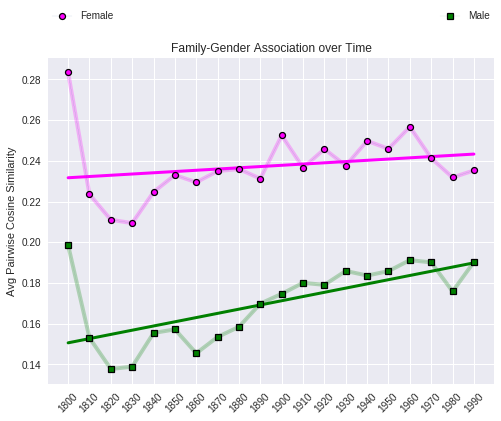

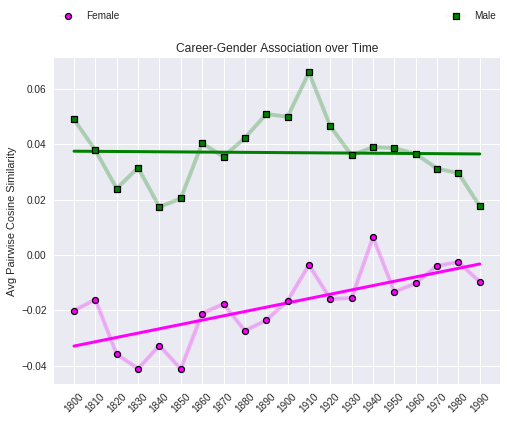

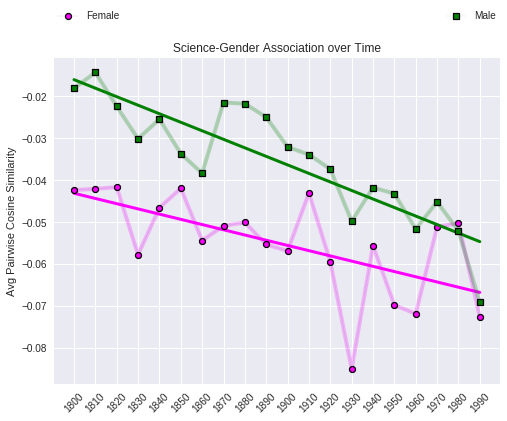

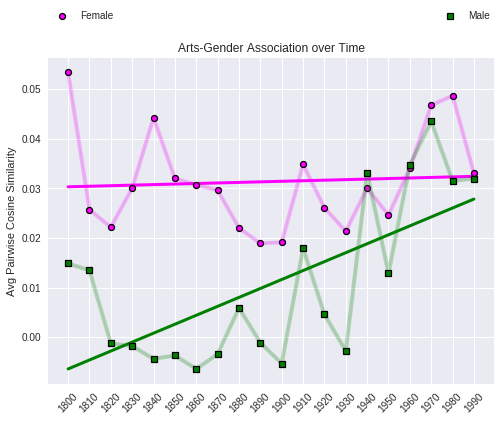

In [4]:
regression_params, gender_association = plot_male_female_association(gender_profile_lang)

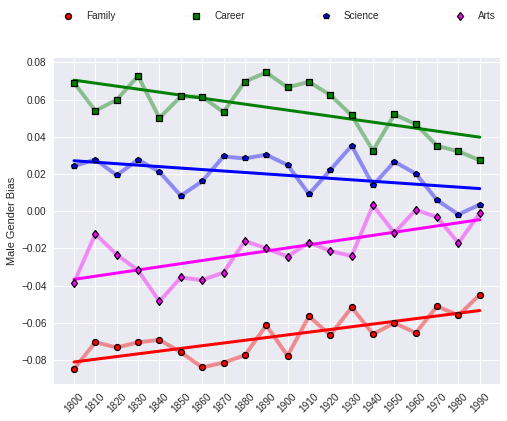

In [5]:
regression_params, bias_scores = compute_bias_against_weat(gender_profile_lang)

# Plot Using Pairwise Distance in l2

In [6]:
domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]


gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=0, end=200)

gender_profile_lang.load_weat_words()
gender_profile_lang.create_data_store_stats(group="general", method="l2")
print("Done!")

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  general l2
PSD:  

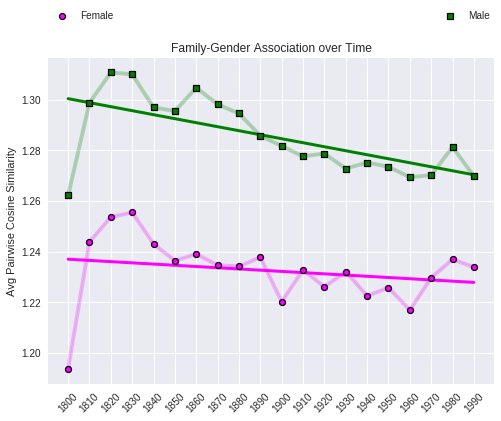

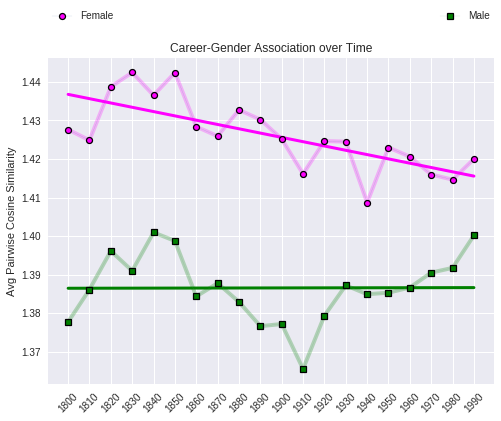

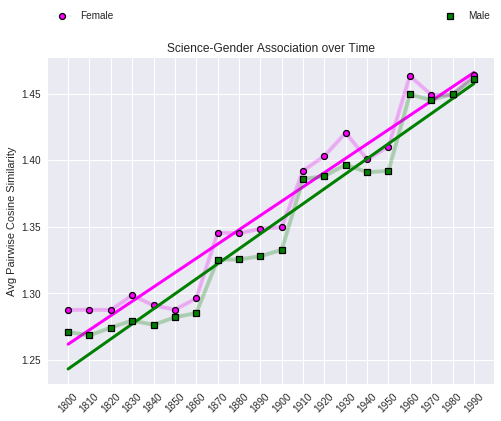

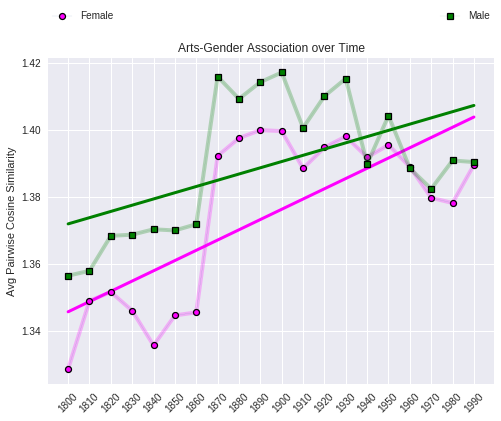

In [7]:
regression_params, gender_association = plot_male_female_association(gender_profile_lang)

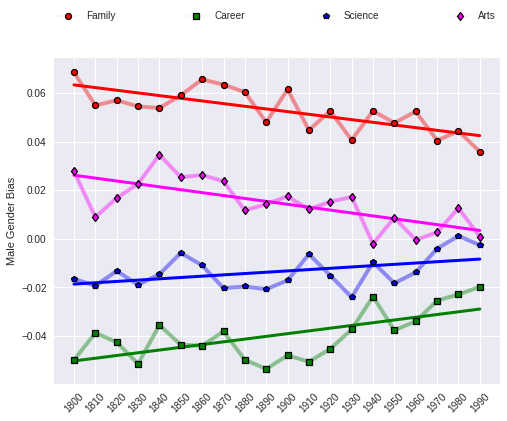

In [8]:
regression_params, bias_scores = compute_bias_against_weat(gender_profile_lang)

# Plot Using Distance from Centroid in l1

In [9]:
domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]


gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=0, end=200)

gender_profile_lang.load_weat_words()
gender_profile_lang.create_data_store_stats(group="centroid", method="l1")
print("Done!")

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  centroid l1
ACD:  

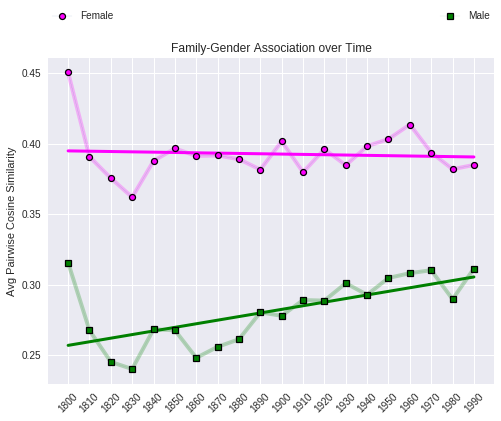

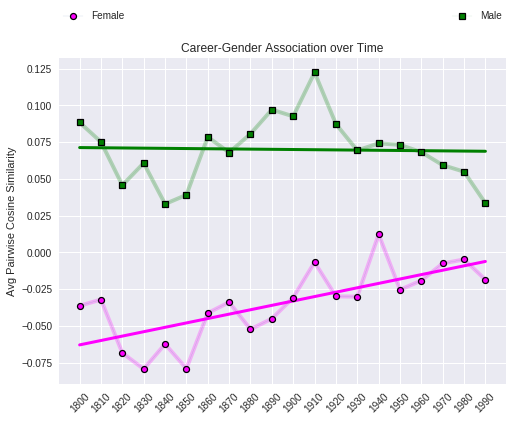

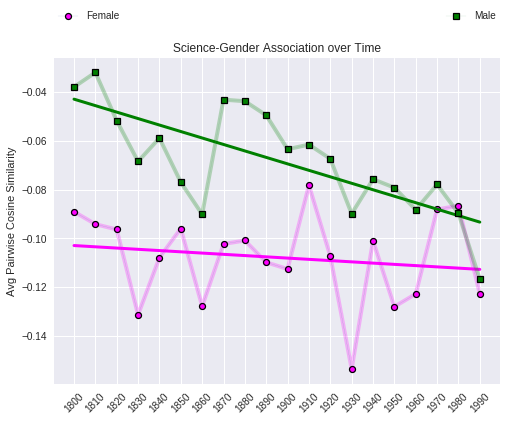

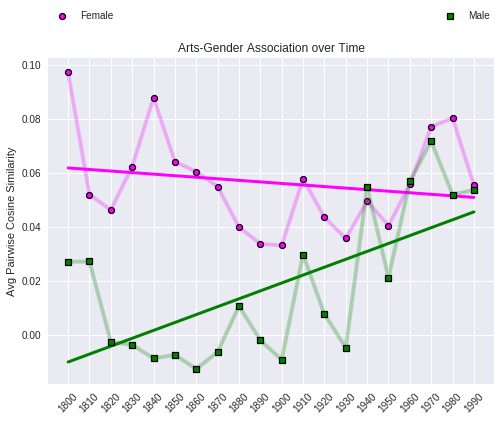

In [10]:
regression_params, gender_association = plot_male_female_association(gender_profile_lang)

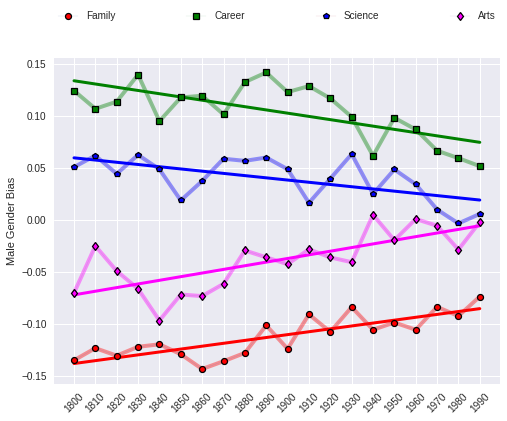

In [11]:
regression_params, bias_scores = compute_bias_against_weat(gender_profile_lang)

# Plot Using Distance from Centroid in l2

In [12]:
domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family", \
                "WEAT_Topic_Career", "WEAT_Topic_Science", "WEAT_Topic_Arts"]


gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=0, end=200)

gender_profile_lang.load_weat_words()
gender_profile_lang.create_data_store_stats(group="centroid", method="l2")
print("Done!")

WEAT Dataset Loading
WEAT_Topic_Career ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Arts ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture', 'shakespeare']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
WEAT_Topic_Science ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  centroid l2
ACD:  

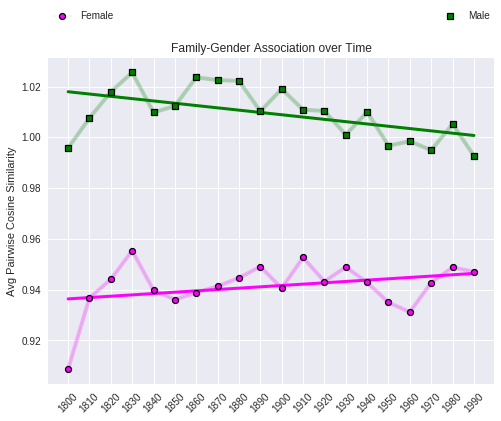

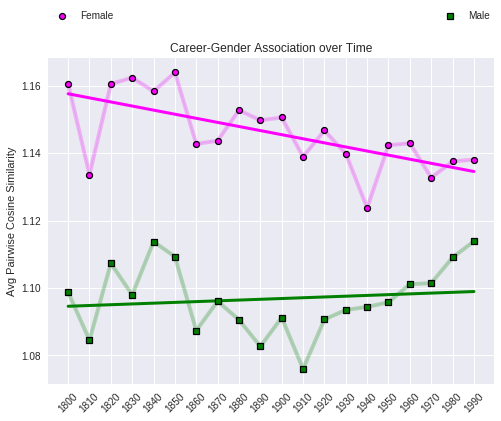

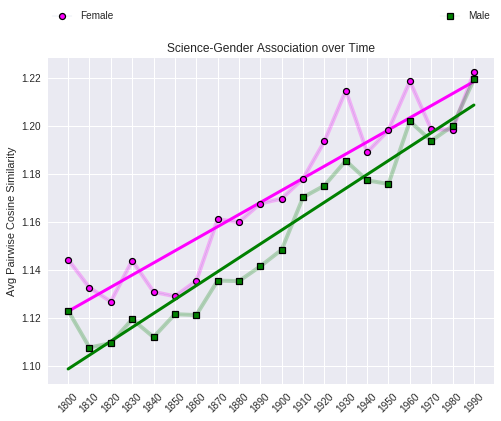

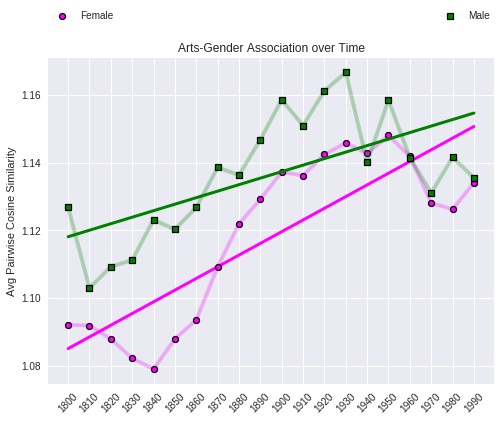

In [13]:
regression_params, gender_association = plot_male_female_association(gender_profile_lang)

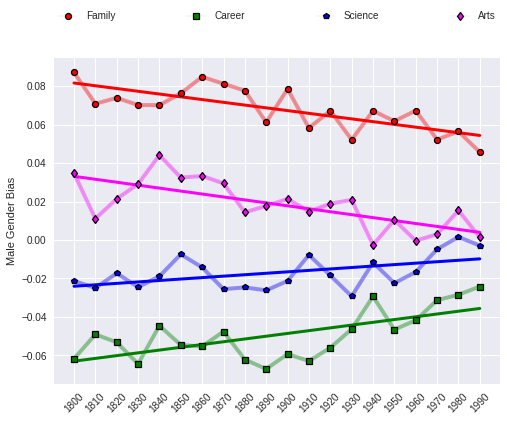

In [14]:
regression_params, bias_scores = compute_bias_against_weat(gender_profile_lang)